### Step 1: Import Libraries & Load Data

In [1]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from scipy.stats import ttest_rel
from itertools import product

# Load the Likert responses CSV
df = pd.read_csv("../data/likert_responses.csv")
df.head()

,participant,question,phase,response
0,1,Are you currently enrolled in a university deg...,unspecified,No
1,2,Are you currently enrolled in a university deg...,unspecified,Yes
2,3,Are you currently enrolled in a university deg...,unspecified,Yes
3,4,Are you currently enrolled in a university deg...,unspecified,Yes
4,5,Are you currently enrolled in a university deg...,unspecified,Yes


### Step 2: Normalize Likert Values

In [2]:
# Mapping from Likert text to numeric
likert_map = {
    "1 - Strongly disagree": 1,
    "2 - Disagree": 2,
    "3 - Neither disagree or agree": 3,
    "3 - Neither diagree or agree": 3,
    "4 - Agree": 4,
    "5 - Strongly agree": 5,
    "1 - Very ineffective": 1,
    "2 - Ineffective": 2,
    "3 - Neither effective or ineffective": 3,
    "4 - Effective": 4,
    "5 - Very effective": 5,
    "1 - Never": 1,
    "2 - Rarely": 2,
    "3 - Sometimes": 3,
    "4 - Often": 4,
    "5 - Always": 5,
    "1 - Very Low": 1,
    "2 - Low": 2,
    "3 - Average": 3,
    "4 - High": 4,
    "5 - Very high": 5,
    "5 - Very High": 5,  # duplicated capitalization
    "1 - Strongly Disagree": 1,  # typo variant
    "3 - Neither unconfident or confident": 3,
    "2 - Unconfident": 2,
    "4 - Confident": 4,
    "5 - Very confident": 5,
}

# Filter and convert
df["score"] = df["response"].map(likert_map)
df = df.dropna(subset=["score"])
df["score"] = df["score"].astype(int)
df.head()

,participant,question,phase,response,score
42,1,I have felt cheerful and in good spirits. (Que...,before,4 - Often,4
43,2,I have felt cheerful and in good spirits. (Que...,before,3 - Sometimes,3
44,3,I have felt cheerful and in good spirits. (Que...,before,3 - Sometimes,3
45,4,I have felt cheerful and in good spirits. (Que...,before,5 - Always,5
46,5,I have felt cheerful and in good spirits. (Que...,before,3 - Sometimes,3


### Step 3: Descriptive Statistics per Question & Phase

In [3]:
# Descriptive stats grouped by question and phase
desc_stats = df.groupby(["question", "phase"])["score"].describe()
desc_stats.head()

count      mean  \
question                                           phase                     
Did you feel disconnected from your academic or... after    21.0  2.952381   
                                                   before   21.0  2.714286   
                                                   during   21.0  3.761905   
Did you feel pressure to appear constantly avai... after    21.0  3.476190   
                                                   before   21.0  3.047619   

                                                                std  min  25%  \
question                                           phase                        
Did you feel disconnected from your academic or... after   0.804748  2.0  2.0   
                                                   before  1.055597  1.0  2.0   
                                                   during  1.135991  2.0  3.0   
Did you feel pressure to appear constantly avai... after   1.030488  2.0  3.0   
                                                   before  0.920662  1.0  3.0   

                                                           50%  75%  max  
question                                           phase                  
Did you feel disconnected from your academic or... after   3.0  3.0  5.0  
                                                   before  2.0  4.0  4.0  
                                                   during  4.0  5.0  5.0  
Did you feel pressure to appear constantly avai... after   3.0  4.0  5.0  
                                                   before  3.0  4.0  4.0

### Step 4: Paired t-Tests for Repeated Measures

In [4]:
# === Pivot for t-tests ===
wide_df = df.pivot_table(index="participant", columns=["question", "phase"], values="score")

# === Paired t-tests (only valid phase comparisons) ===
valid_pairs = [("before", "during"), ("during", "after"), ("before", "after")]
t_results = []

for question in wide_df.columns.get_level_values(0).unique():
    available_phases = wide_df[question].dropna(axis=1, how='all').columns
    for p1, p2 in valid_pairs:
        if p1 in available_phases and p2 in available_phases:
            a = wide_df[question][p1].dropna()
            b = wide_df[question][p2].dropna()
            merged = pd.merge(a, b, left_index=True, right_index=True)
            if len(merged) >= 5:
                tstat, pval = ttest_rel(merged.iloc[:, 0], merged.iloc[:, 1])
                t_results.append({
                    "question": question,
                    "phase_1": p1,
                    "phase_2": p2,
                    "t_stat": round(tstat, 3),
                    "p_value": round(pval, 4),
                    "n": len(merged)
                })

t_results_df = pd.DataFrame(t_results)
t_results_df.head()

,question,phase_1,phase_2,t_stat,p_value,n
0,Did you feel disconnected from your academic o...,before,during,-2.624,0.0163,21
1,Did you feel disconnected from your academic o...,during,after,3.442,0.0026,21
2,Did you feel disconnected from your academic o...,before,after,-0.755,0.4593,21
3,Did you feel pressure to appear constantly ava...,before,during,-1.000,0.3293,21
4,Did you feel pressure to appear constantly ava...,during,after,-0.810,0.4276,21


### Step 5: Boxplots

C:\Users\julia\AppData\Local\Temp\ipykernel_19124\3552183134.py:24: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.boxplot(data=subset, x="phase", y="score", palette="Set2")


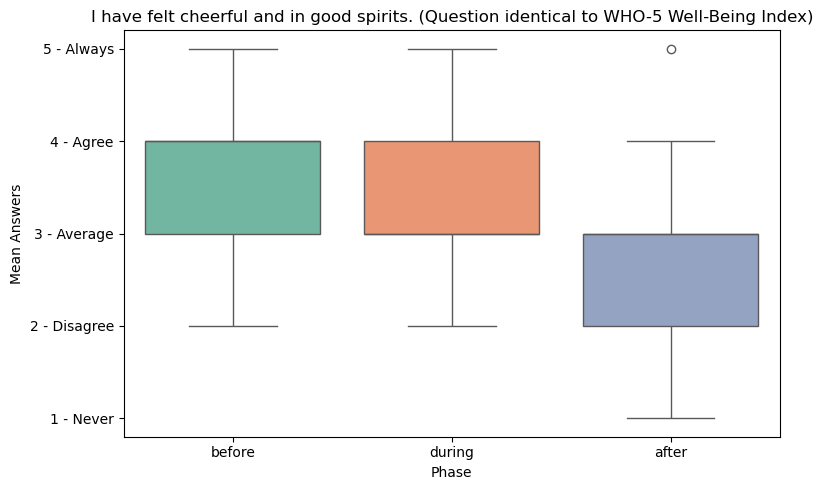

C:\Users\julia\AppData\Local\Temp\ipykernel_19124\3552183134.py:24: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.boxplot(data=subset, x="phase", y="score", palette="Set2")


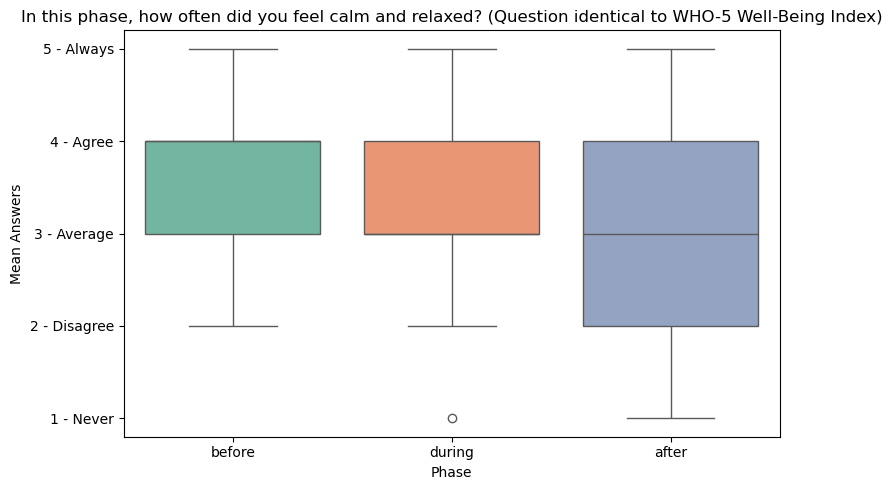

C:\Users\julia\AppData\Local\Temp\ipykernel_19124\3552183134.py:24: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.boxplot(data=subset, x="phase", y="score", palette="Set2")


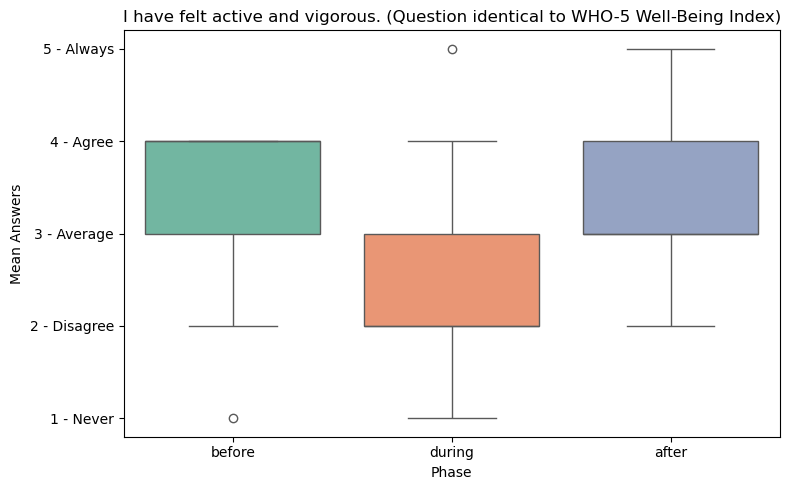

C:\Users\julia\AppData\Local\Temp\ipykernel_19124\3552183134.py:24: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.boxplot(data=subset, x="phase", y="score", palette="Set2")


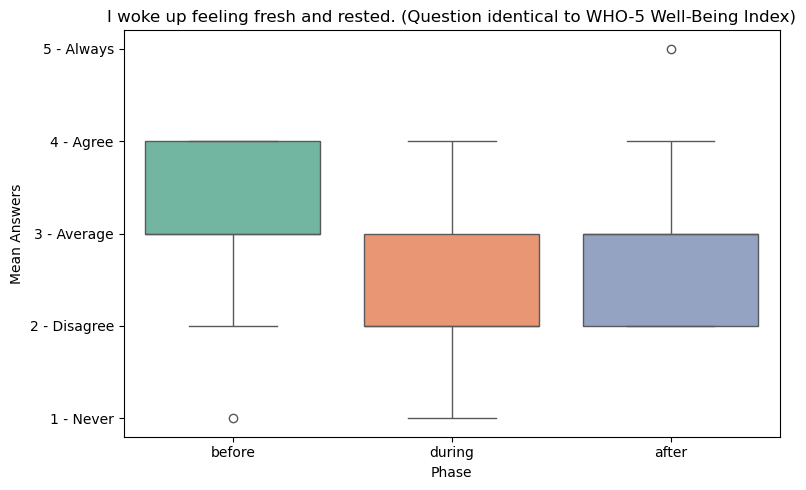

C:\Users\julia\AppData\Local\Temp\ipykernel_19124\3552183134.py:24: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.boxplot(data=subset, x="phase", y="score", palette="Set2")


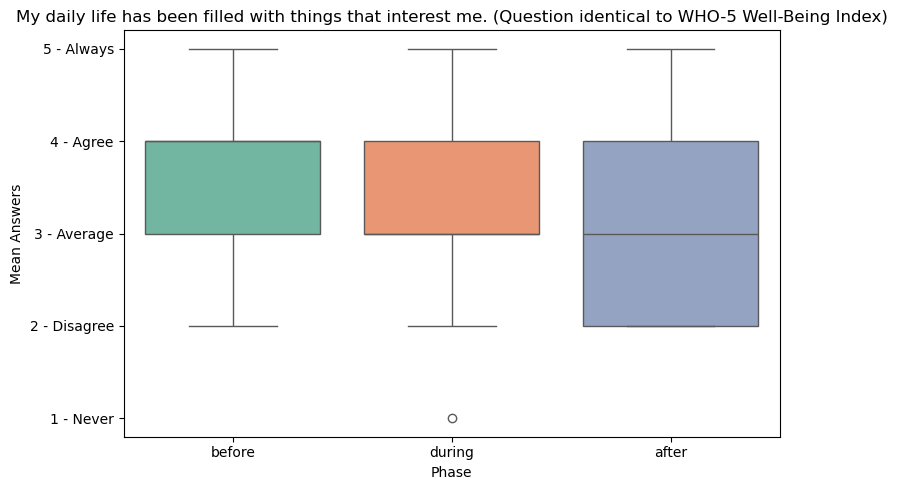

C:\Users\julia\AppData\Local\Temp\ipykernel_19124\3552183134.py:24: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.boxplot(data=subset, x="phase", y="score", palette="Set2")


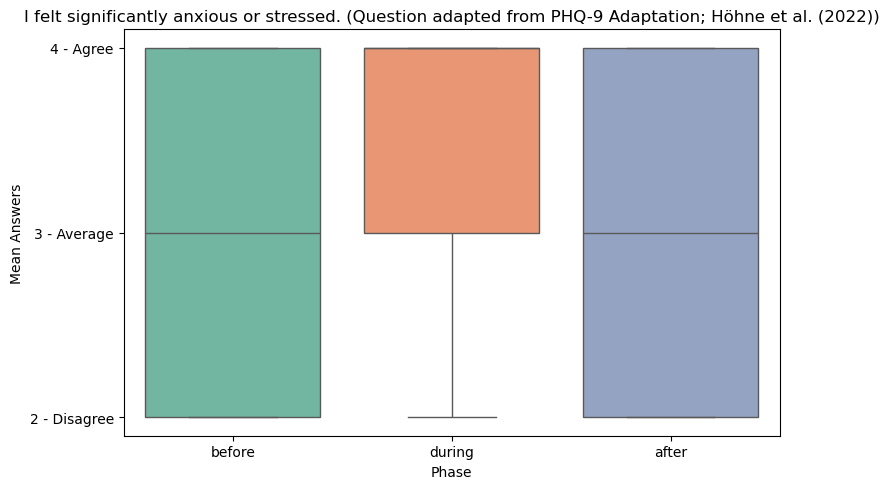

C:\Users\julia\AppData\Local\Temp\ipykernel_19124\3552183134.py:24: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.boxplot(data=subset, x="phase", y="score", palette="Set2")


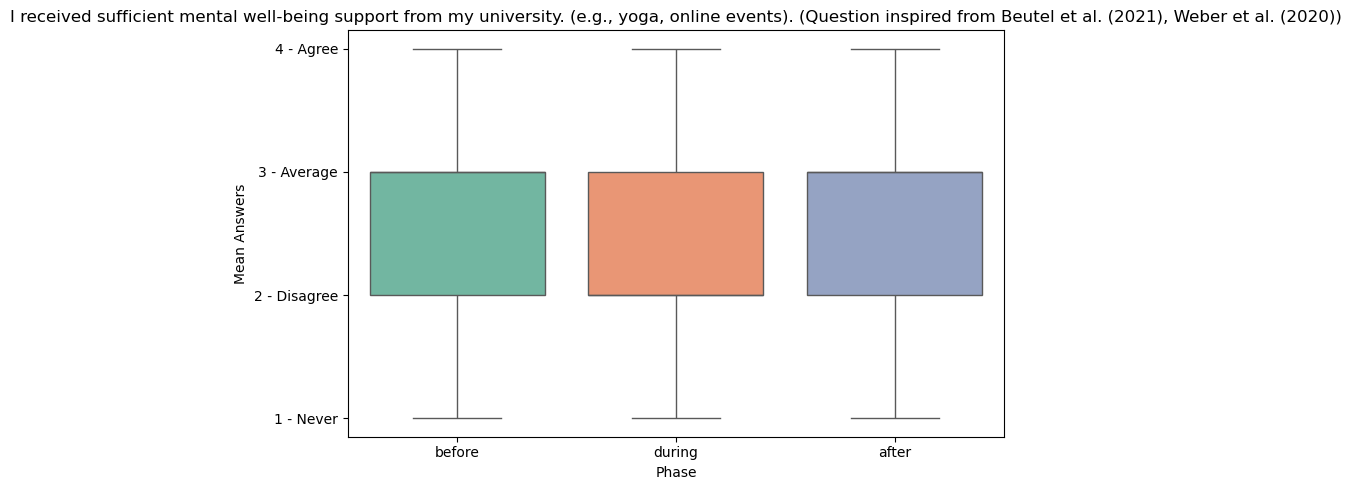

C:\Users\julia\AppData\Local\Temp\ipykernel_19124\3552183134.py:24: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.boxplot(data=subset, x="phase", y="score", palette="Set2")


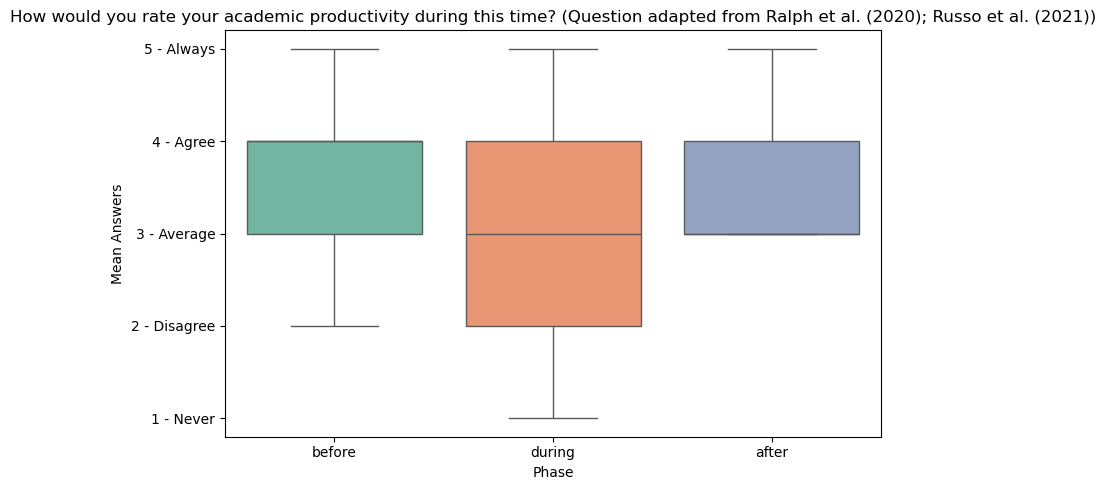

C:\Users\julia\AppData\Local\Temp\ipykernel_19124\3552183134.py:24: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.boxplot(data=subset, x="phase", y="score", palette="Set2")


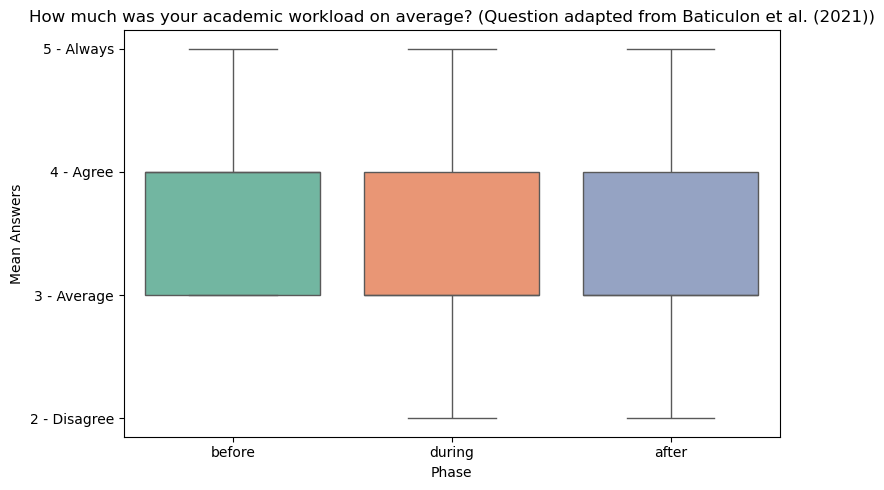

C:\Users\julia\AppData\Local\Temp\ipykernel_19124\3552183134.py:24: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.boxplot(data=subset, x="phase", y="score", palette="Set2")


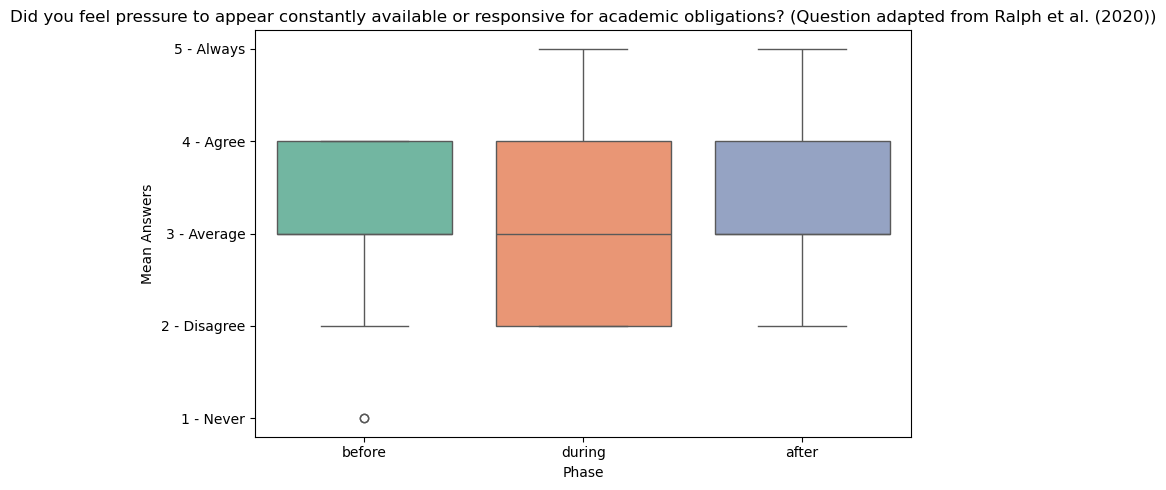

C:\Users\julia\AppData\Local\Temp\ipykernel_19124\3552183134.py:24: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.boxplot(data=subset, x="phase", y="score", palette="Set2")


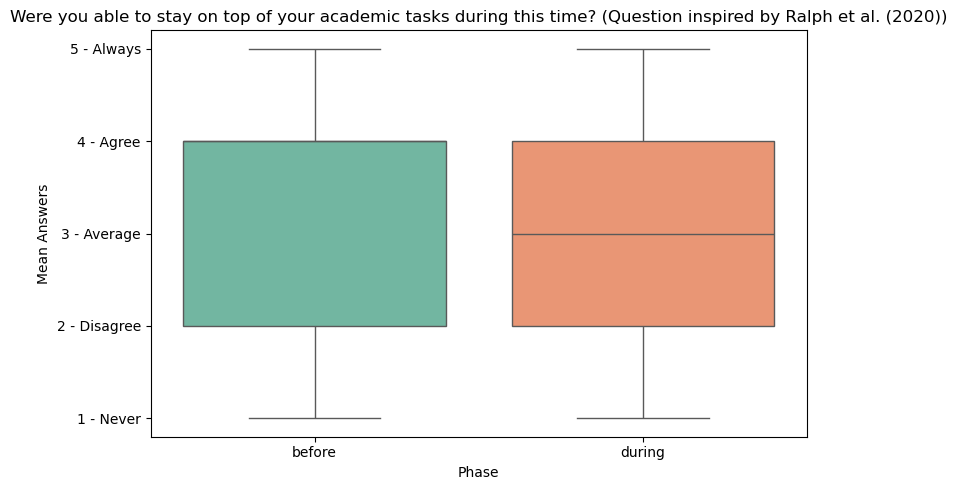

C:\Users\julia\AppData\Local\Temp\ipykernel_19124\3552183134.py:24: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.boxplot(data=subset, x="phase", y="score", palette="Set2")


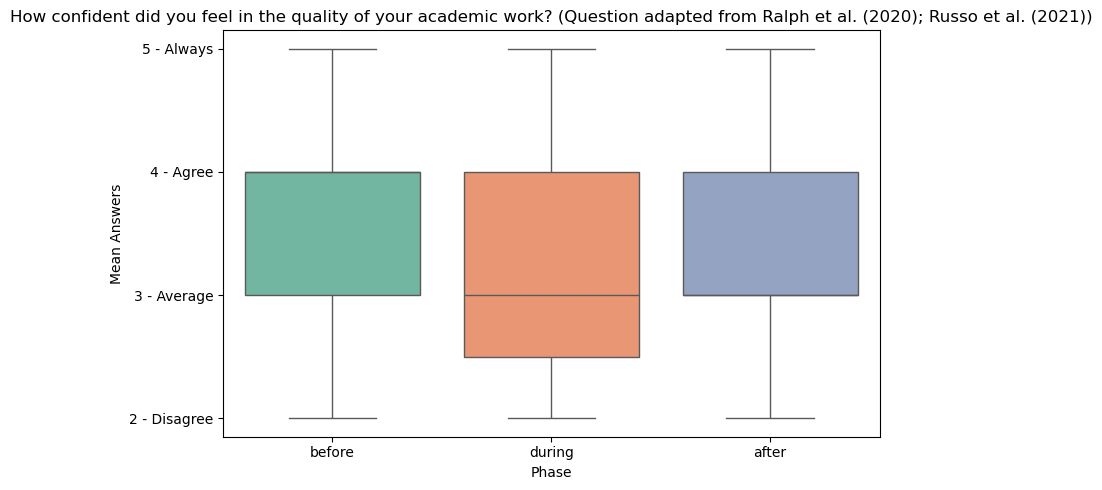

C:\Users\julia\AppData\Local\Temp\ipykernel_19124\3552183134.py:24: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.boxplot(data=subset, x="phase", y="score", palette="Set2")


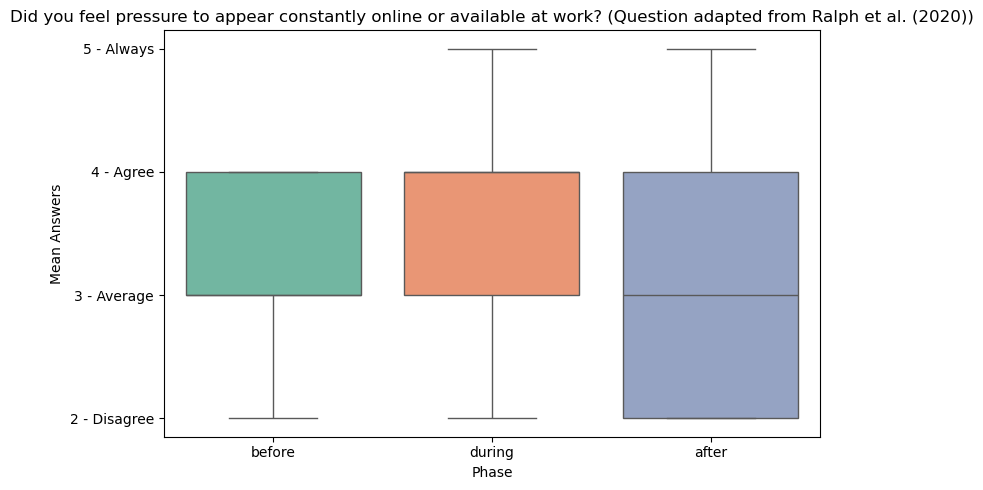

C:\Users\julia\AppData\Local\Temp\ipykernel_19124\3552183134.py:24: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.boxplot(data=subset, x="phase", y="score", palette="Set2")


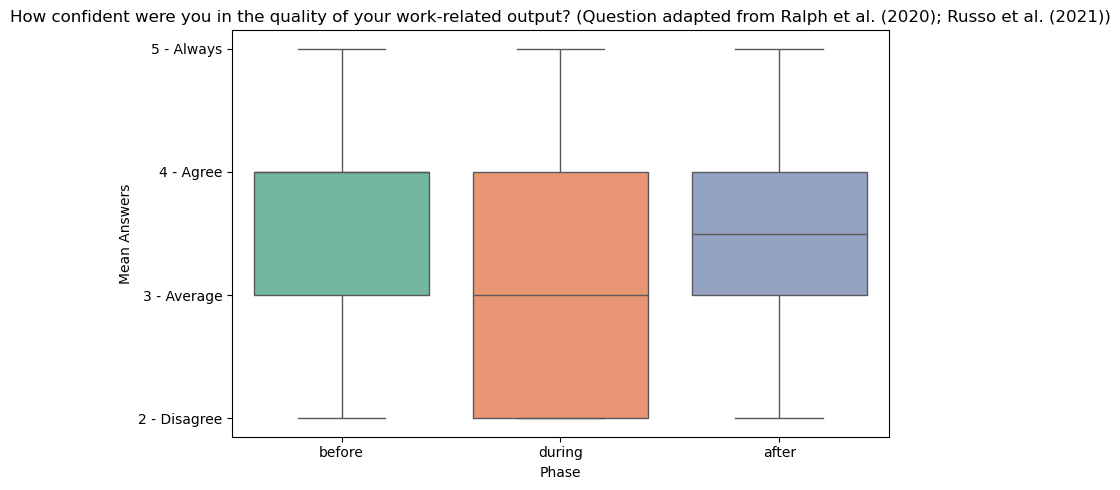

C:\Users\julia\AppData\Local\Temp\ipykernel_19124\3552183134.py:24: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.boxplot(data=subset, x="phase", y="score", palette="Set2")


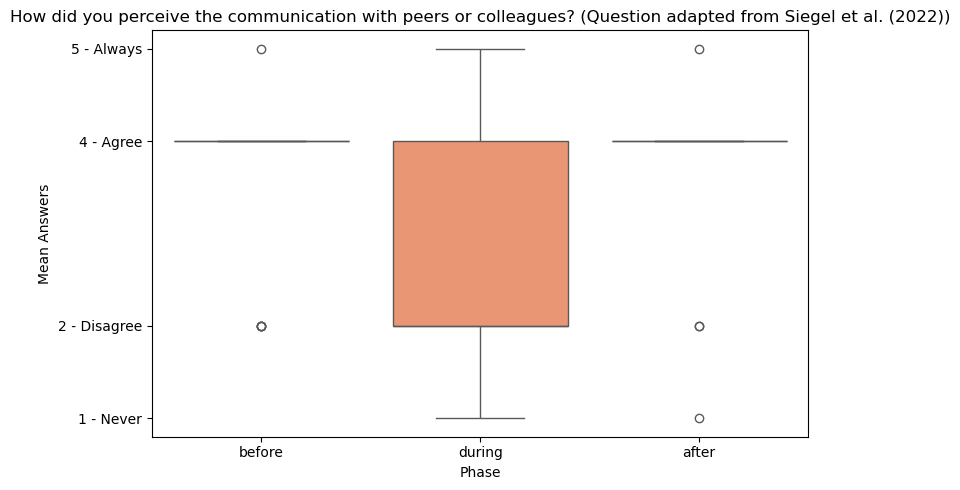

C:\Users\julia\AppData\Local\Temp\ipykernel_19124\3552183134.py:24: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.boxplot(data=subset, x="phase", y="score", palette="Set2")


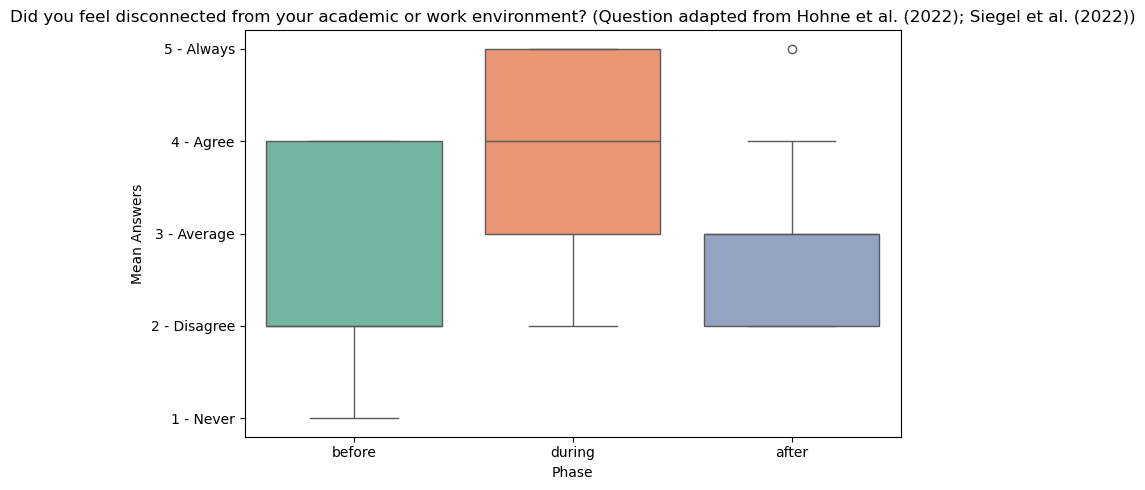

C:\Users\julia\AppData\Local\Temp\ipykernel_19124\3552183134.py:24: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.boxplot(data=subset, x="phase", y="score", palette="Set2")


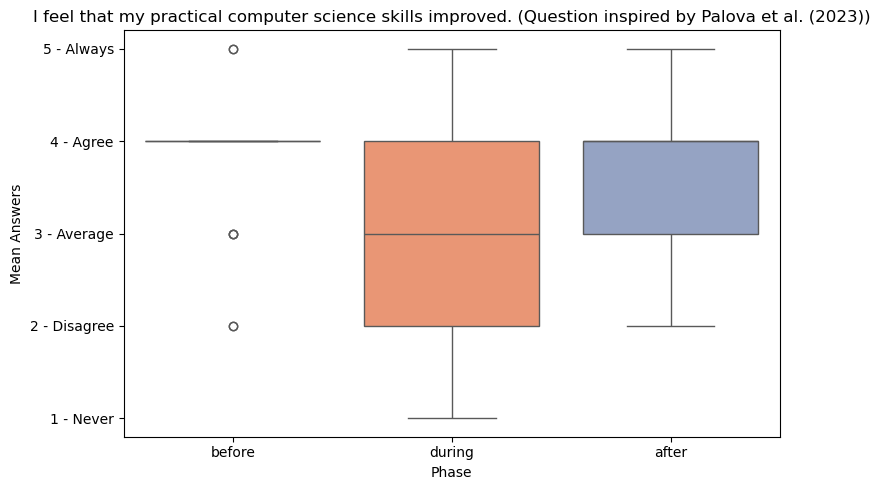

In [5]:
# Invert your mapping to get: {question_key: response_text}
reverse_map = {}
for text, score in likert_map.items():
    reverse_map.setdefault(score, set()).add(text)

# Normalize response labels by score
standardized_labels = {
    score: sorted(list(labels))[0]  # Pick one representative per score
    for score, labels in reverse_map.items()
}

likert_numeric = df.copy()

# Plotting with auto-detected y-ticks
for question in likert_numeric["question"].unique():
    subset = likert_numeric[likert_numeric["question"] == question]
    if subset["phase"].nunique() < 2:
        continue

    scores_used = sorted(subset["score"].unique())
    y_labels = [standardized_labels.get(score, str(score)) for score in scores_used]

    plt.figure(figsize=(8, 5))
    sns.boxplot(data=subset, x="phase", y="score", palette="Set2")
    plt.title(question)
    plt.xlabel("Phase")
    plt.ylabel("Mean Answers")
    plt.yticks(ticks=scores_used, labels=y_labels)
    plt.tight_layout()
    plt.show()